In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigvalsh, qr
from numpy import linalg as lg

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [2]:
def label_plaquettes(l, ax, labels = None):
    for i, p in enumerate(l.plaquettes):
        x, y = p.center
        ax.text(x, y, f"{i}" if labels is None else labels[i],
                ha = 'center', va = 'center', fontsize = 10)

def plot_vertices(l, subset = slice(None,None)):
    #slice(None,None) just acts like the : in array[:]
    axes[0].scatter(*honeycomb.vertices.positions[subset].T);
    
def plot_plaquette_set(l, subset, color, alpha = 0.5, **kwargs):
    plaquette_labels = [0 if i in subset else 1 for i in range(l.n_plaquettes)]
    color_scheme = [color, "None"]
    plotting.plot_plaquettes(l, plaquette_labels, color_scheme = color_scheme, polygon_args = dict(alpha = alpha), **kwargs)

def plot_edge_set(l, subset, color, **kwargs):
    edge_labels = [0 if i in subset else 1 for i in range(l.n_edges)]
    color_scheme = [color, "None"]
    plotting.plot_lattice(lattice = l, edge_labels = edge_labels, edge_color_scheme = color_scheme, **kwargs)

# Get a coloring

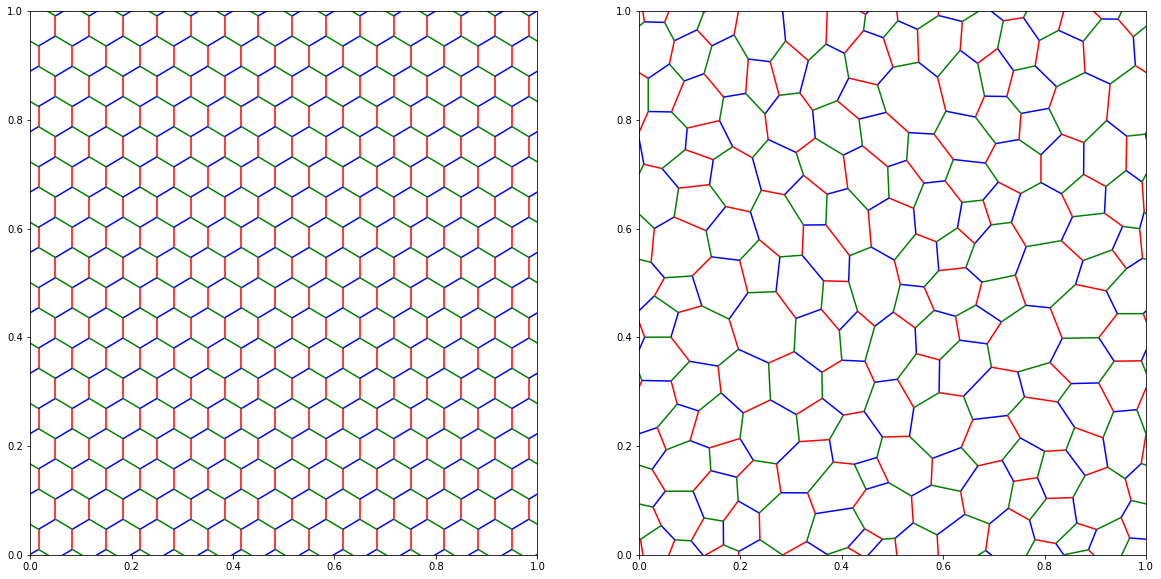

In [3]:
from koala import voronization, plotting, pointsets, example_graphs
from koala import graph_utils, graph_color

n = 15

cmap = plt.get_cmap("tab10")
color_scheme = cmap([0,1])
#color_scheme = np.array(plotting.peru_friendly_colour_scheme(4))[[1,3,2,0]]

vertex_color_scheme = ['red', 'blue']

honeycomb, honeycomb_labels = example_graphs.generate_honeycomb(n, return_colouring=True)

random_points = pointsets.generate_bluenoise(k = 30, nx = n, ny = n)
amorphous = voronization.generate_lattice(random_points, shift_vertices=True)
amorphous_labels = graph_color.color_lattice(amorphous)

f, axes = plt.subplots(ncols = 2, figsize = (20, 10))
plotting.plot_lattice(honeycomb, ax = axes[0], edge_labels = honeycomb_labels)
plotting.plot_lattice(amorphous, ax = axes[1], edge_labels = amorphous_labels);

# Get AB sublattices
For the amorphous lattice they're not real sublattices but we define them arbitrarily along the red bonds.

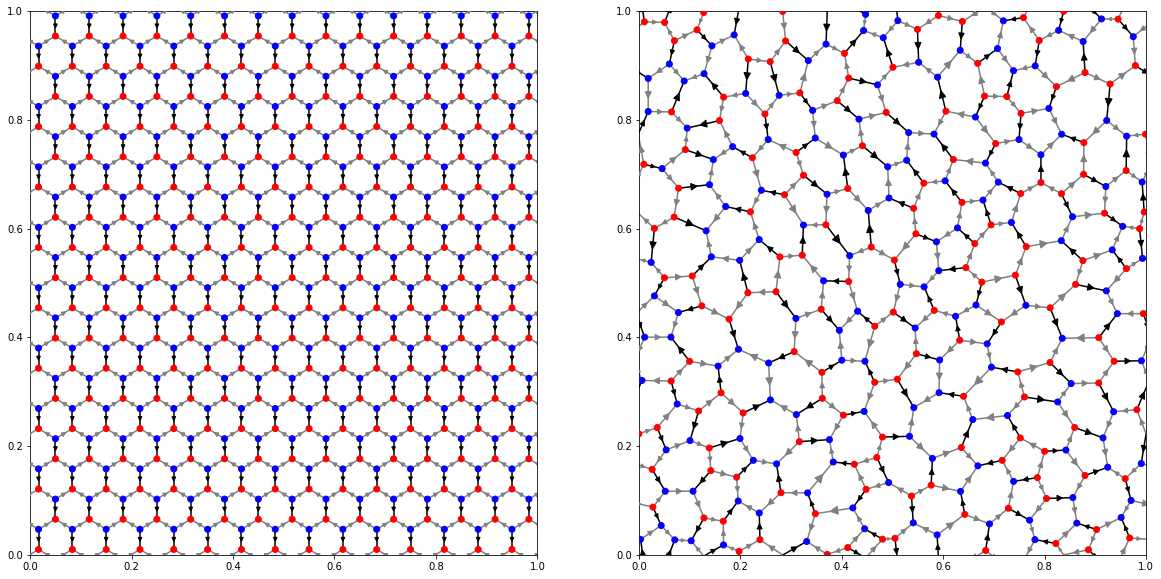

In [4]:
from koala import hamiltonian

honeycomb_sublattice_labels = np.arange(honeycomb.n_vertices) % 2

amorphous = hamiltonian.bisect_lattice(amorphous, amorphous_labels, 0)
amorphous_sublattice_labels = np.asarray(np.arange(amorphous.n_vertices) < (amorphous.n_vertices//2), dtype = int)

f, axes = plt.subplots(ncols = 2, figsize = (20, 10))
plotting.plot_lattice(honeycomb, ax = axes[0], edge_labels = honeycomb_labels, 
                      vertex_labels = honeycomb_sublattice_labels, vertex_color_scheme = vertex_color_scheme,
                     edge_color_scheme = ['black', 'grey', 'grey'],
                     edge_arrows = True) 

plotting.plot_lattice(amorphous, ax = axes[1], edge_labels = amorphous_labels, 
                      vertex_labels = amorphous_sublattice_labels,
                      vertex_color_scheme = vertex_color_scheme,
                      edge_color_scheme = ['black', 'grey', 'grey'],
                      edge_arrows = True
                     );

# Take a look at the plaquettes

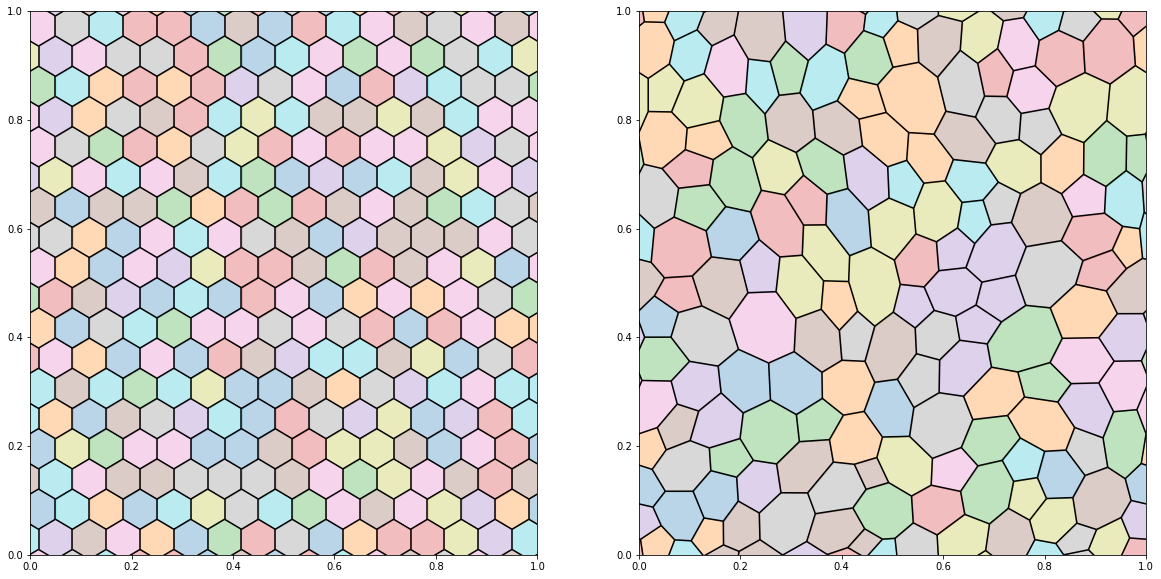

In [5]:
cmap = plt.get_cmap("tab10")

def plot_plaquettes_random_colours(l, ax):
    plaq_labels = np.arange(l.n_plaquettes)
    color_scheme = cmap(np.random.randint(10, size = l.n_plaquettes))
    plotting.plot_plaquettes(l, plaq_labels, color_scheme = color_scheme, ax = ax, polygon_args = dict(alpha = 0.3))
    plotting.plot_lattice(l, ax = ax)

f, axes = plt.subplots(ncols = 2, figsize = (20, 10))
plot_plaquettes_random_colours(honeycomb, axes[0])
plot_plaquettes_random_colours(amorphous, axes[1])

# Choose random $U_{ij} = \pm1$ and evaluate the fluxes.
Arrows points along the $U_{ij} = +1$ direction

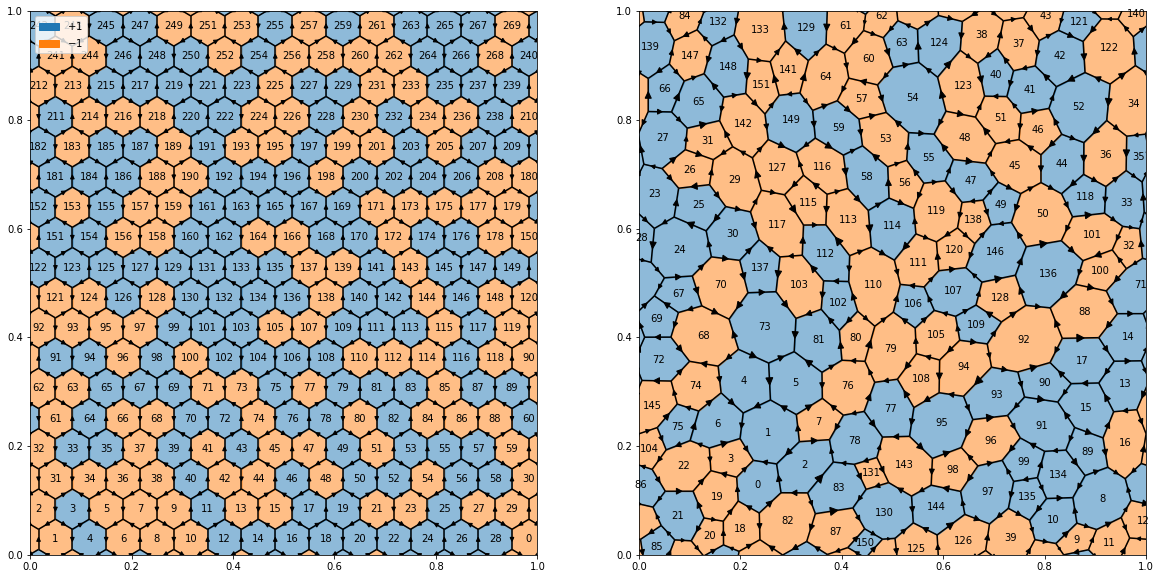

In [6]:
from koala.flux_finder import fluxes_from_bonds, fluxes_to_labels, _random_bonds

def plot_bonds_and_fluxes(l, ax, bonds = None):
    if bonds is None:
        rng = np.random.default_rng()
        bonds = 1 - 2*rng.choice(2, size = l.n_edges)
    
    fluxes = fluxes_from_bonds(l, bonds)
    plaquette_labels = fluxes_to_labels(fluxes)
    
    plotting.plot_plaquettes(l, plaquette_labels, color_scheme = color_scheme, ax = ax, polygon_args = dict(alpha = 0.5))
    plotting.plot_lattice(l, ax = ax, edge_arrows = True, bond_signs = bonds)
    label_plaquettes(l, ax = ax)
    
honeycomb_random_bonds = _random_bonds(honeycomb)
amorphous_random_bonds = _random_bonds(amorphous)

honeycomb_random_fluxes = fluxes_from_bonds(honeycomb, honeycomb_random_bonds)
amorphous_random_fluxes = fluxes_from_bonds(amorphous, amorphous_random_bonds)
    
f, axes = plt.subplots(ncols = 2, figsize = (20, 10))
plot_bonds_and_fluxes(honeycomb, axes[0], bonds = honeycomb_random_bonds)
plot_bonds_and_fluxes(amorphous, axes[1], bonds = amorphous_random_bonds)

import matplotlib.patches as mpatches
def patch(color, label):return mpatches.Patch(color=color, label=label)
axes[0].legend(handles = [patch(c, l) for c,l in zip(color_scheme, ['$+ 1$', '$- 1$']) ]);

# As a first pass, flip adjacent -1/i plaquettes
Edges flipped in red

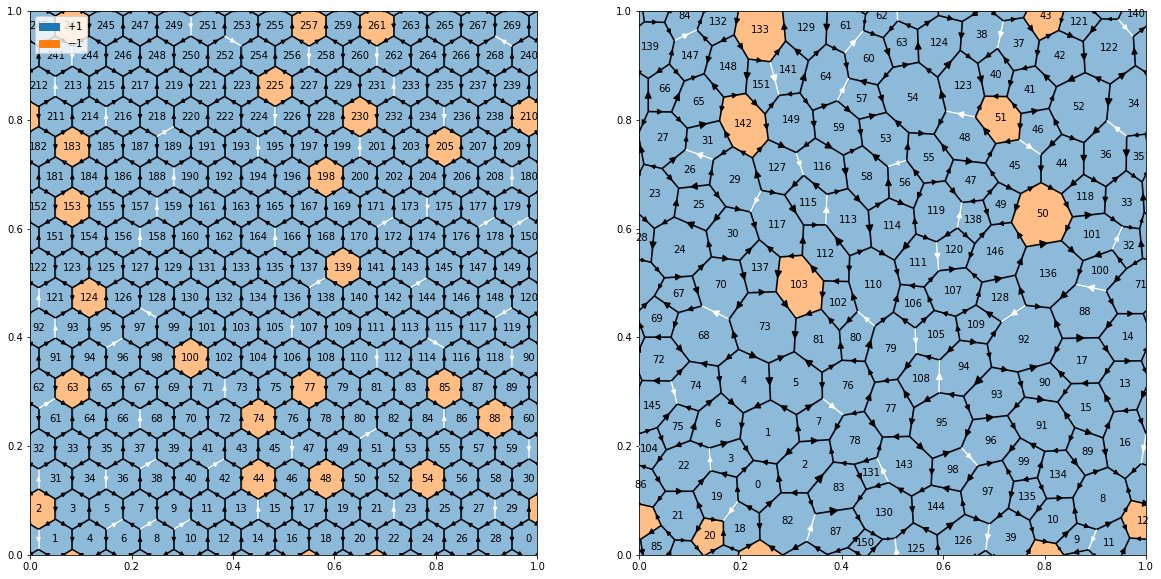

In [7]:
from koala.flux_finder import _flip_adjacent_fluxes

edge_color_scheme = ['black', 'white']

def plot_bonds_and_fluxes_edge_color(l, ax, bonds = None, edge_labels = None, alpha = 0.5):
    fluxes = fluxes_from_bonds(l, bonds)
    plaquette_labels = fluxes_to_labels(fluxes)
    
    plotting.plot_plaquettes(l, plaquette_labels, color_scheme = color_scheme, ax = ax, polygon_args = dict(alpha = alpha))
    plotting.plot_lattice(l, ax = ax, edge_arrows = True, bond_signs = bonds, 
                          edge_labels = edge_labels, edge_color_scheme = edge_color_scheme)
    label_plaquettes(l, ax = ax)

def random_and_improved(l, bonds, fluxes):
    return _flip_adjacent_fluxes(l, bonds.copy(), fluxes.copy())

honeycomb_better_bonds, honeycomb_better_fluxes = random_and_improved(honeycomb, honeycomb_random_bonds, honeycomb_random_fluxes)
amorphous_better_bonds, amorphous_better_fluxes = random_and_improved(amorphous, amorphous_random_bonds, amorphous_random_fluxes)

f, axes = plt.subplots(ncols = 2, figsize = (20, 10))
plot_bonds_and_fluxes_edge_color(honeycomb, axes[0], bonds = honeycomb_better_bonds, edge_labels = (honeycomb_random_bonds != honeycomb_better_bonds).astype(int))
plot_bonds_and_fluxes_edge_color(amorphous, axes[1], bonds = amorphous_better_bonds, edge_labels = (amorphous_random_bonds != amorphous_better_bonds).astype(int))

axes[0].legend(handles = [patch(c, l) for c,l in zip(color_scheme, ['$+ 1$', '$- 1$']) ]);

# Now pair off the remaining plaquettes
This uses a naive greedy algorithm that just picks a point and pairs it with its closest neighbour. Can be replaced if this is slow.

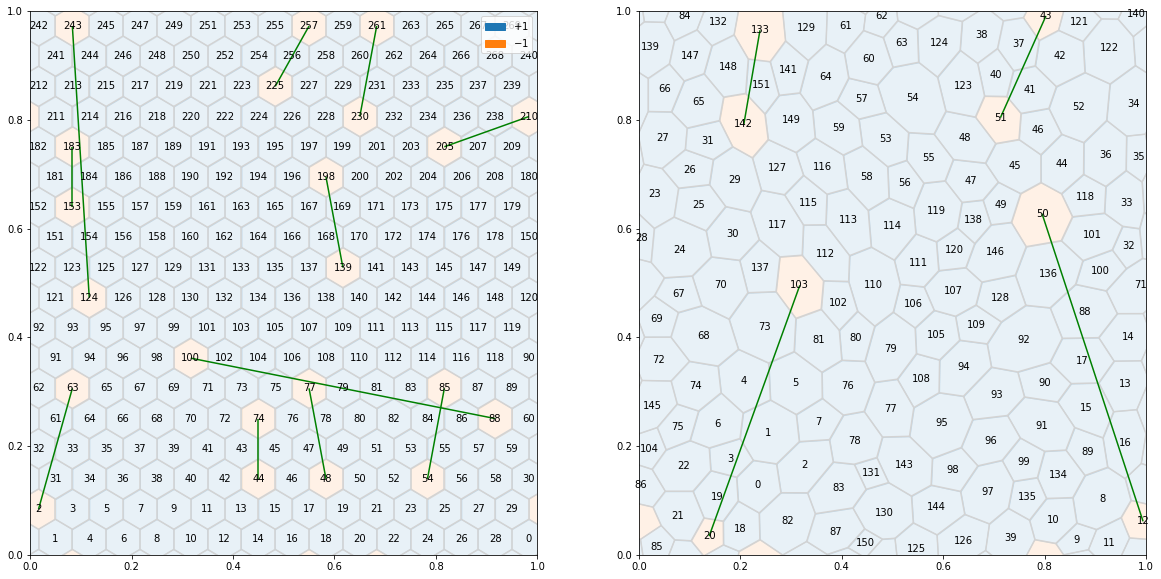

In [8]:
from koala.flux_finder import _greedy_plaquette_pairing
from koala.pathfinding import straight_line_length, periodic_straight_line_length

def plaquette_metric(l):
    def d(a,b): return straight_line_length(l.plaquettes[a].center, l.plaquettes[b].center)
    return d

def plot_bad_flux_pairing(l, bonds, fluxes, ax):
    bad_fluxes = np.nonzero(fluxes == -1)[0]
    pairs = _greedy_plaquette_pairing(bad_fluxes, distance_func = plaquette_metric(l))

    fluxes = fluxes_from_bonds(l, bonds)
    plaquette_labels = fluxes_to_labels(fluxes)
    plotting.plot_plaquettes(l, plaquette_labels, color_scheme = color_scheme, ax = ax, polygon_args = dict(alpha = 0.1))

    plotting.plot_lattice(l, edge_color_scheme = ['lightgrey'], ax = ax)

    label_plaquettes(l, ax, np.arange(l.n_plaquettes))

    def pos(i): return l.plaquettes[i].center
    lines = [[pos(a),pos(b)] for a,b in pairs]

    from matplotlib.collections import LineCollection
    lines = LineCollection(lines, color = 'green')
    ax.add_collection(lines)
    
    return pairs
    
f, axes = plt.subplots(ncols = 2, figsize = (20, 10))  

honeycomb_pairs = plot_bad_flux_pairing(honeycomb, honeycomb_better_bonds, honeycomb_better_fluxes, axes[0])
amorphous_pairs = plot_bad_flux_pairing(amorphous, amorphous_better_bonds, amorphous_better_fluxes, axes[1])

axes[0].legend(handles = [patch(c, l) for c,l in zip(color_scheme, ['$+ 1$', '$- 1$']) ]);

# Now turn those pairs into flux tubes on the lattice using A*

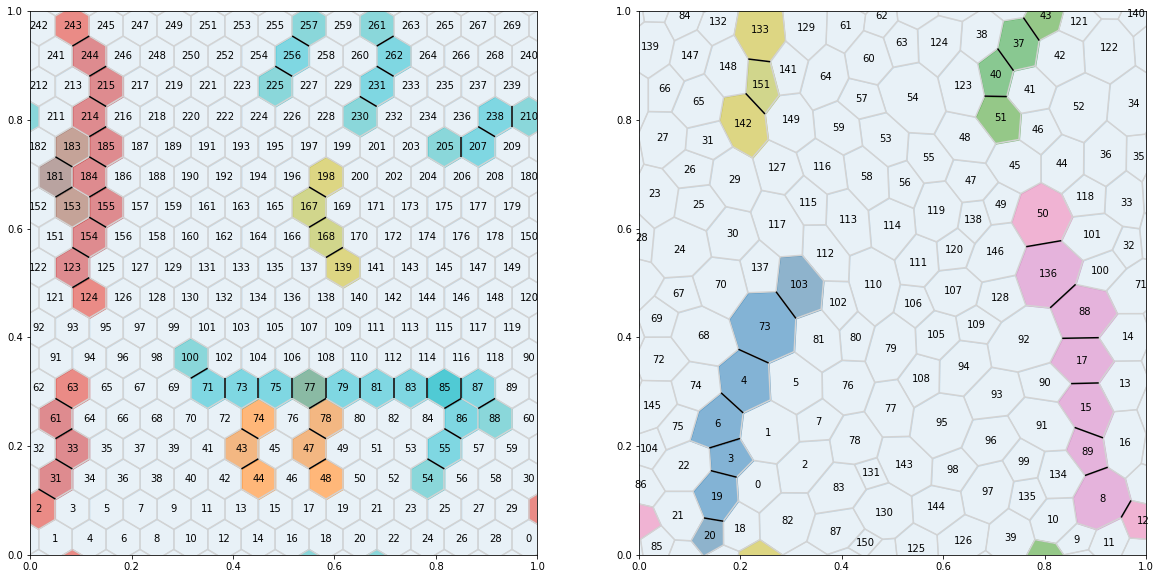

In [9]:
from koala.flux_finder import _greedy_plaquette_pairing
from koala.pathfinding import straight_line_length, periodic_straight_line_length, path_between_plaquettes

path_kw = dict(heuristic = straight_line_length)

def plot_paths(l, fluxes, pairs, ax):
    plaquette_labels = fluxes_to_labels(fluxes)
    plotting.plot_plaquettes(l, plaquette_labels, color_scheme = color_scheme, ax = ax, polygon_args = dict(alpha = 0.1))
    plotting.plot_lattice(l, edge_color_scheme = ['lightgrey'], ax = ax)
    label_plaquettes(l, ax, np.arange(l.n_plaquettes))
    
    plaquette_paths, edge_paths = zip(*(path_between_plaquettes(l, a, b, **path_kw) for a,b in pairs))
    
    for plaqs, edges in zip(plaquette_paths, edge_paths):
        color = cmap(np.random.randint(10))
        plot_plaquette_set(l, plaqs, color, ax=ax)
        plot_edge_set(l, edges, color = 'black', ax=ax)
    
    return edge_paths
    
f, axes = plt.subplots(ncols = 2, figsize = (20, 10))  

honeycomb_edges_to_flip = plot_paths(honeycomb, honeycomb_better_fluxes, honeycomb_pairs, axes[0])
amorphous_edges_to_flip = plot_paths(amorphous, amorphous_better_fluxes, amorphous_pairs, axes[1])

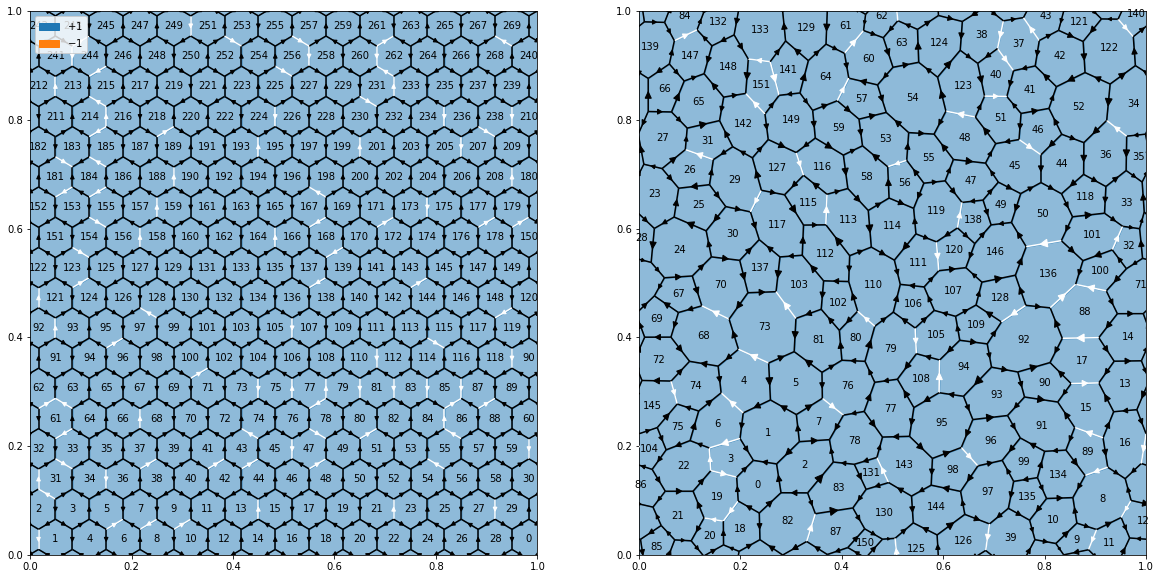

In [10]:
def flip(l, bonds, to_flip):
    #gotta be careful about edges we want to flip multiple times
    bonds = bonds.copy()
    for path in to_flip:
        bonds[path] *= -1
    return bonds, fluxes_from_bonds(l, bonds)

honeycomb_final_bonds, honeycomb_final_fluxes = flip(honeycomb, honeycomb_better_bonds, honeycomb_edges_to_flip)
amorphous_final_bonds, amorphous_final_fluxes = flip(amorphous, amorphous_better_bonds, amorphous_edges_to_flip)

f, axes = plt.subplots(ncols = 2, figsize = (20, 10))
plot_bonds_and_fluxes_edge_color(honeycomb, axes[0], bonds = honeycomb_final_bonds, edge_labels = (honeycomb_random_bonds != honeycomb_final_bonds).astype(int))
plot_bonds_and_fluxes_edge_color(amorphous, axes[1], bonds = amorphous_final_bonds, edge_labels = (amorphous_random_bonds != amorphous_final_bonds).astype(int))


axes[0].legend(handles = [patch(c, l) for c,l in zip(color_scheme, ['$+ 1$', '$- 1$']) ]);

# And here's doing all that in one function

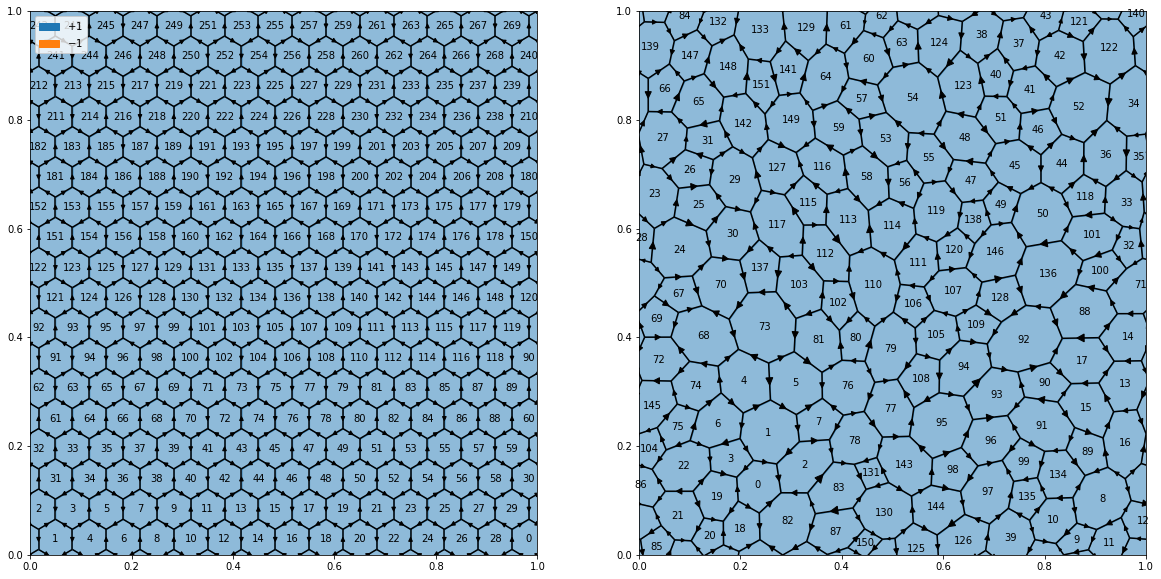

In [11]:
from koala.flux_finder import find_flux_sector

def plot_bonds_and_fluxes(l, ax, bonds = None):
    bonds = find_flux_sector(l)
    fluxes = fluxes_from_bonds(l, bonds)
    plaquette_labels = fluxes_to_labels(fluxes)
    
    plotting.plot_plaquettes(l, plaquette_labels, color_scheme = color_scheme, ax = ax, polygon_args = dict(alpha = 0.5))
    plotting.plot_lattice(l, ax = ax, edge_arrows = True, bond_signs = bonds)
    label_plaquettes(l, ax = ax)
    
f, axes = plt.subplots(ncols = 2, figsize = (20, 10))
plot_bonds_and_fluxes(honeycomb, axes[0])
plot_bonds_and_fluxes(amorphous, axes[1])

axes[0].legend(handles = [patch(c, l) for c,l in zip(color_scheme, ['$+ 1$', '$- 1$']) ]);